In [1]:
#Imports & Settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")


In [2]:
#Load & Inspect
df = pd.read_csv('C:/Users/AHVINAV/ML-Python/Mechademy_Assessment/data.csv') 
print("Rows,Cols:", df.shape)
df.head()

Rows,Cols: (16857, 29)


,timestamp,equipment_energy_consumption,lighting_energy,zone1_temperature,zone1_humidity,zone2_temperature,zone2_humidity,zone3_temperature,zone3_humidity,zone4_temperature,...,zone9_temperature,zone9_humidity,outdoor_temperature,atmospheric_pressure,outdoor_humidity,wind_speed,visibility_index,dew_point,random_variable1,random_variable2
0,2016-01-11 17:00:00,60.0,-77.78778596503064,33.74660933896648,47.59666666666671,19.2,44.790000,19.79,NaN,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.300000,13.275433,13.275433
1,2016-01-11 17:10:00,60.0,30.0,19.89,46.69333333333329,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.200000,18.606195,18.606195
2,2016-01-11 17:20:00,50.0,30.0,19.89,46.3,19.2,44.626667,19.79,44.933333,35.921144,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.100000,28.642668,28.642668
3,2016-01-11 17:30:00,50.0,40.0,33.74660933896648,46.0666666666667,19.2,44.590000,19.79,45.000000,NaN,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,37.673716,45.410389,45.410389
4,2016-01-11 17:40:00,60.0,40.0,19.89,46.33333333333329,19.2,44.530000,19.79,45.000000,18.890000,...,4.476511,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.900000,10.084097,10.084097


In [3]:
# Clean “bad” strings → NaN
df.replace(['???','error','check','NA','nan'], np.nan, inplace=True)

# Datetime features
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df['hour']       = df['timestamp'].dt.hour
df['day_of_week']= df['timestamp'].dt.dayofweek

# Clean target column (convert non-numeric values to NaN and drop those rows)
df['equipment_energy_consumption'] = pd.to_numeric(
    df['equipment_energy_consumption'], errors='coerce'
)
df = df.dropna(subset=['equipment_energy_consumption']).reset_index(drop=True)

In [4]:
# Target & feature split
y = df['equipment_energy_consumption'].astype(float)
X = df.drop(columns=['timestamp', 'equipment_energy_consumption'])

# Force numeric & impute missing values
X = X.apply(pd.to_numeric, errors='coerce')
X = X.fillna(X.mean())

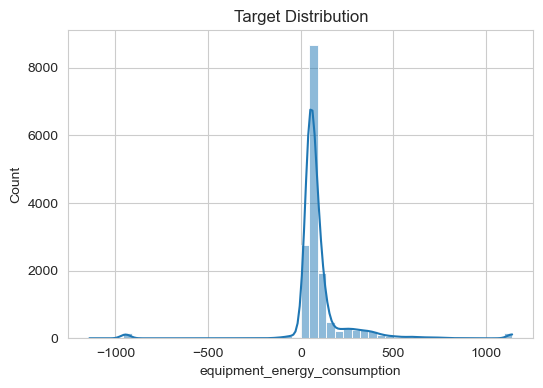

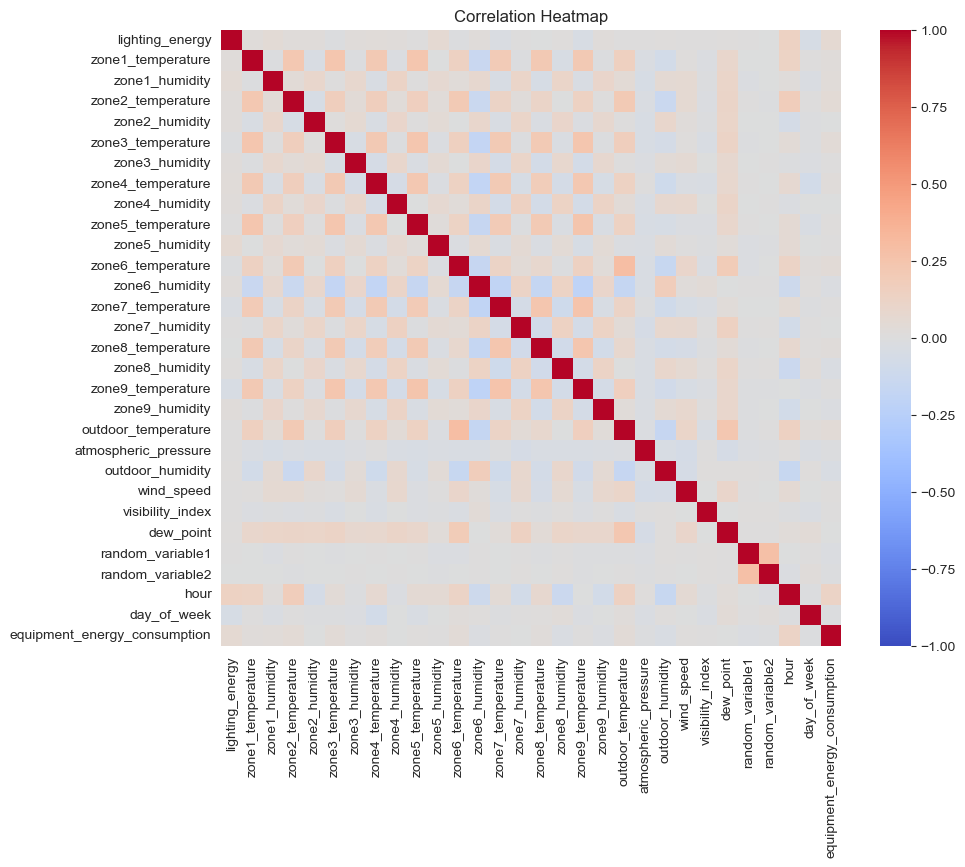

In [5]:
# EDA (brief)
plt.figure(figsize=(6,4))
sns.histplot(y, bins=50, kde=True)
plt.title("Target Distribution"); plt.show()

plt.figure(figsize=(10,8))
sns.heatmap(pd.concat([X, y], axis=1).corr(), cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap"); plt.show()

In [6]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


In [7]:
# Model definitions
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42)
}

In [8]:
# Train & Evaluate
results = {}
for name, m in models.items():
    m.fit(X_train, y_train)
    p = m.predict(X_test)
    results[name] = {
        "RMSE": np.sqrt(mean_squared_error(y_test, p)),
        "MAE": mean_absolute_error(y_test, p),
        "R2": r2_score(y_test, p)
    }

res_df = pd.DataFrame(results).T
print(res_df)

                        RMSE        MAE        R2
LinearRegression  162.069515  71.841028  0.021570
Ridge             162.069503  71.841009  0.021570
RandomForest      159.124327  68.615269  0.056808


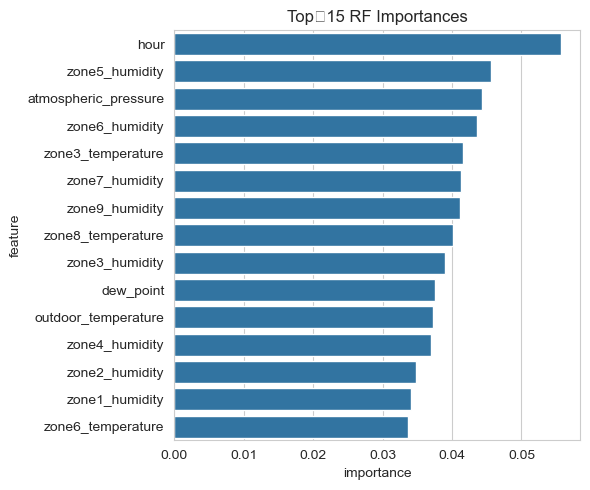

In [9]:
# Feature Importance (RF)
rf = models["RandomForest"]
imp = pd.DataFrame({
    "feature": X.columns,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False).head(15)

plt.figure(figsize=(6,5))
sns.barplot(x="importance", y="feature", data=imp)
plt.title("Top‑15 RF Importances"); plt.tight_layout(); plt.show()

In [10]:
# Insights & Recommendations
print("""
1. **Zone temperatures** (zones 1–4) & **outdoor temp** are strongest predictors—optimize HVAC in these areas.
2. **Lighting energy** has moderate influence—consider LED upgrades or smart controls.
3. **Random variables** had near‑zero importance; dropping them is justified.
4. Energy peaks by **hour** suggest shifting non‑critical loads to off‑peak hours.
5. Implement real‑time monitoring on high‑impact zones to dynamically adjust equipment usage.
""")



1. **Zone temperatures** (zones 1–4) & **outdoor temp** are strongest predictors—optimize HVAC in these areas.
2. **Lighting energy** has moderate influence—consider LED upgrades or smart controls.
3. **Random variables** had near‑zero importance; dropping them is justified.
4. Energy peaks by **hour** suggest shifting non‑critical loads to off‑peak hours.
5. Implement real‑time monitoring on high‑impact zones to dynamically adjust equipment usage.

